In [7]:
import pandas as pd
import numpy as np
import eia
import requests
import json
import yaml
from prophet import Prophet

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')   

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# To be able to pull modules from src folder 
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

In [4]:
from d00_utils.const import *
from d00_utils.utils import setup_env_vars, load_yml, get_filepath

setup_env_vars()
os.environ.get("EIA_ACCESS_KEY")

2022-03-09 15:54:36.161 INFO    d00_utils.utils: Finding .env file to load entries as environment variables...
2022-03-09 15:54:36.164 INFO    d00_utils.utils: Finished loading environment variables.


'xPWAeqwYEwqmxA0hFnjsCUbcyxEG95ajpq4aX89p'

## Mapping Emissions Intensity by State 
So far, we've calculated the associated emissions for each state at each point in time. I want to test if we can somehow represent this information on a map graph of all the US states to directly compare the emissions intensity of the different states at one glance. 

A level further would be to have this view for different points in time to see how states have gotten their generation more greener with time. 

In [56]:
# Sample emissions data for testing: 
filepath = '../data/06_reporting/Emission_Forecasts/Total_Emissions/AL-CO2e-Emissions.csv'

df = pd.read_csv(filepath)
df.head()

,date,coal,natural_gas,nuclear,hydro,wind,solar_all,other,all_fuels
0,2001-03-31,18306.736,1290.926,95.284,61.929,0.000,0.000,33.808,19788.683
1,2001-06-30,17297.901,1616.734,89.210,37.527,0.000,0.000,31.222,19072.594
2,2001-09-30,21167.729,2271.226,111.064,36.239,0.000,0.000,32.869,23619.128
3,2001-12-31,17030.293,2044.878,99.084,39.789,0.000,0.000,32.213,19246.257
4,2002-03-31,15075.478,2048.159,107.925,52.695,0.000,0.000,32.488,17316.745


In [57]:
# Combine Emissions data into one state prior to mapping 
states = ['AL', 'AR']
emissions_combined = pd.DataFrame()
for state in states: 
    filepath = '../data/06_reporting/Emission_Forecasts/Total_Emissions/{}-CO2e-Emissions.csv'.format(state)
    df = pd.read_csv(filepath)
    df["state"] = state
    emissions_combined = pd.concat([emissions_combined, df], ignore_index=True)
emissions_combined['date'] = pd.to_datetime(emissions_combined['date'], format='%Y-%m-%d')

# Test concatenation
emissions_combined.state.value_counts()
# emissions_combined

AL    100
AR    100
Name: state, dtype: int64

### Implemented Combining of data into one csv for all states

In [87]:
# Sample emissions data for testing: 
filepath1 = '../data/06_reporting/Emission_Forecasts/Combined-CO2e-Total-Emissions.csv'
filepath2 = '../data/06_reporting/Emission_Forecasts/Combined-CO2e-Emissions-Intensity.csv'

df_total = pd.read_csv(filepath1)
df_intensity = pd.read_csv(filepath2)

df_total['date'] = pd.to_datetime(df_total['date'], format='%Y-%m-%d')
df_intensity['date'] = pd.to_datetime(df_intensity['date'], format='%Y-%m-%d')
df_total.head()

,date,coal,natural_gas,nuclear,hydro,wind,solar_all,other,all_fuels,state
0,2001-03-31,18306.736,1290.926,95.284,61.929,0.000,0.000,33.808,19788.683,AL
1,2001-06-30,17297.901,1616.734,89.210,37.527,0.000,0.000,31.222,19072.594,AL
2,2001-09-30,21167.729,2271.226,111.064,36.239,0.000,0.000,32.869,23619.128,AL
3,2001-12-31,17030.293,2044.878,99.084,39.789,0.000,0.000,32.213,19246.257,AL
4,2002-03-31,15075.478,2048.159,107.925,52.695,0.000,0.000,32.488,17316.745,AL


In [77]:
# Convert both to yearly aggregations
# df_intensity = df_intensity.groupby([pd.Grouper(key='date', freq='Y'), 'state']).mean().reset_index()
df_total = df_total.groupby([pd.Grouper(key='date', freq='Y'), 'state']).sum().reset_index()

,date,state,coal,natural_gas,nuclear,hydro,wind,solar_all,other,all_fuels
0,2001-03-31,AL,18306.736,1290.926,95.284,61.929,0.000,0.000,33.808,19788.683
1,2001-03-31,AR,5492.229,355.129,42.562,18.565,0.000,0.000,11.837,5920.321
2,2001-06-30,AL,17297.901,1616.734,89.210,37.527,0.000,0.000,31.222,19072.594
3,2001-06-30,AR,6116.845,436.192,48.306,13.057,0.000,0.000,9.070,6623.470
4,2001-09-30,AL,21167.729,2271.226,111.064,36.239,0.000,0.000,32.869,23619.128
...,...,...,...,...,...,...,...,...,...,...
195,2025-06-30,AR,4129.377,3119.259,39.548,23.605,0.000,9.010,6.031,7326.832
196,2025-09-30,AL,2870.962,9485.634,159.293,48.361,0.000,0.050,27.983,12592.282
197,2025-09-30,AR,6011.423,3501.944,45.566,20.649,0.000,9.226,6.528,9595.335
198,2025-12-31,AL,242.640,8067.980,151.384,61.373,0.000,0.135,25.946,8549.457


In [83]:
# Get only 2021 datapoints for test map
df_intensity[df_intensity['date'].dt.year == 2021]
# df_total[df_total['date'].dt.year == 2021]

,date,state,emissions_intensity
40,2021-12-31,AL,0.378
41,2021-12-31,AR,0.512


## Plotly Choropleth Chart 

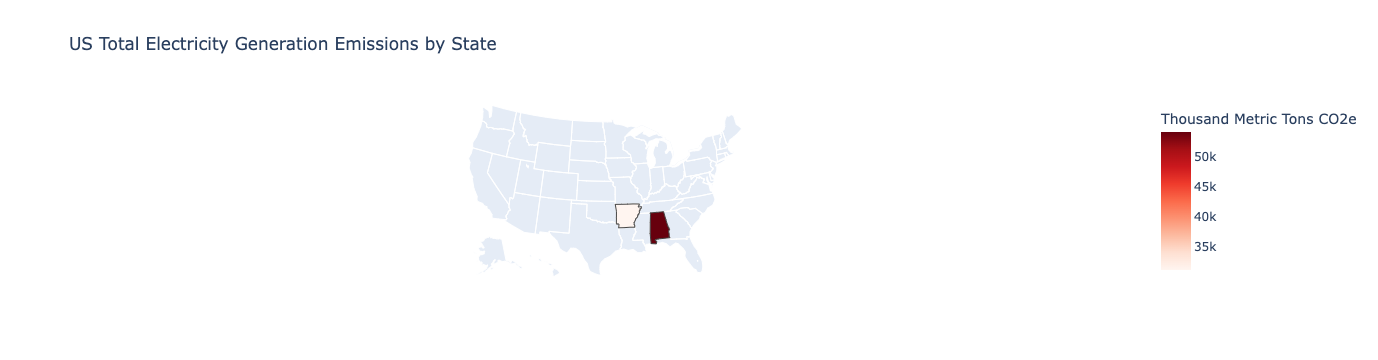

In [86]:
import plotly.graph_objects as go

import pandas as pd
# df = df_intensity[df_intensity['date'].dt.year == 2021]
df = df_total[df_total['date'].dt.year == 2021]

fig = go.Figure(data=go.Choropleth(
    locations=df['state'], # Spatial coordinates
    z = df['all_fuels'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Thousand Metric Tons CO2e",
))

fig.update_layout(
    
    title_text = 'US Total Electricity Generation Emissions by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

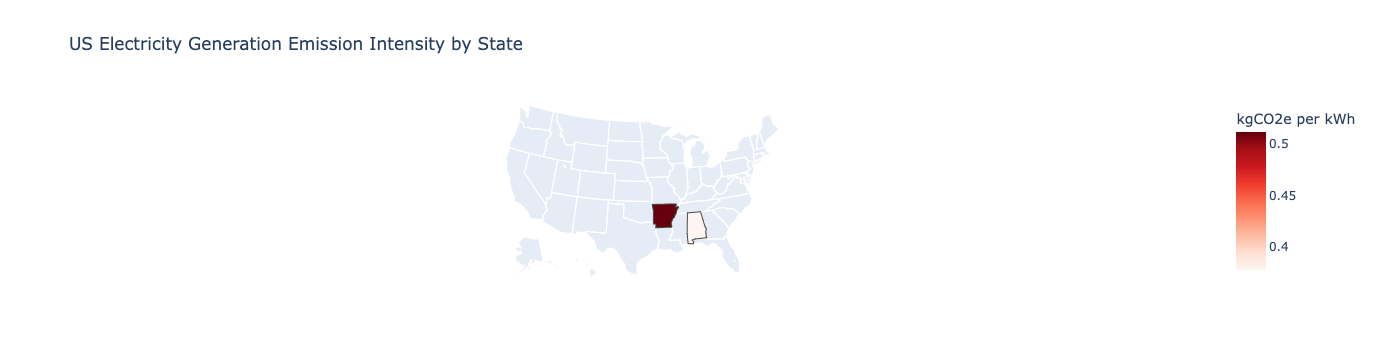

In [85]:
import plotly.graph_objects as go

import pandas as pd
df = df_intensity[df_intensity['date'].dt.year == 2021]

fig = go.Figure(data=go.Choropleth(
    locations=df['state'], # Spatial coordinates
    z = df['emissions_intensity'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "kgCO2e per kWh",
))

fig.update_layout(
    title_text = 'US Electricity Generation Emissions Intensity by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()